## Overall tasks

#### 1.Create a simple ConvNet trained on the labelled data and see if you can get better than random accuracy.
#### 2.See if you can turn this simple ConvNet into an autoencoder and train it using the unlabelled test image data.
#### 3.Use the encoder part of the autoencoder to recreate your ConvNet and train it using the smaller quantity of labelled data and see if you can beat the accuracy of your initial ConvNet.

## Needed Package

In [1]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torchvision import models
import torchvision
from torchvision import transforms
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math
import pandas as pd
from collections import Counter

## Porcess data

In [2]:
#the path to get data from local
TRAIN_DATA_PATH = 'D:\Study and Documents\COMPSCI5103_DL/TRAIN/train'
TEST_DATA_PATH = 'D:\Study and Documents\COMPSCI5103_DL/TEST'
batch_size = 4
workers = 2

#random horizontal flip and normalize for train and validate set
orig_set = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

#Use random_split to split data into two parts(90% train set, 10% validate set)
train_set, val_set = torch.utils.data.random_split(orig_set, [math.floor(len(orig_set)*0.9), math.ceil(len(orig_set)*0.1)])

test_set = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]))

### Use a sampler to change the weight which can handle the unbalanced dataset.

In [ ]:
train_classes = [label for _, label in train_set]

class_count = Counter(train_classes)
class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 

sample_weights = [0] * len(train_set)
for idx, (image, label) in enumerate(train_set):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights,
                                num_samples = len(train_set), replacement=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=workers, sampler=sampler)
validate_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=workers)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=workers)
classes = ('Cancer', 'Connective', 'Immune', 'Normal')

### show weights for every label

In [65]:
class_weights

tensor([3.4382, 3.4152, 3.3553, 8.4530])

### Have a look on some ramdon image from dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


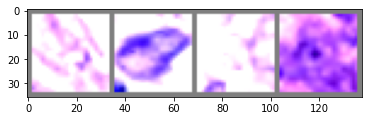

Connective Normal Normal Cancer


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Build the CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Pring CNN parameters

In [5]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


### Define loss function and optimizer

In [6]:
import torch.optim as optim

optimizer = Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

### Train the CNN with train data

In [7]:
loss_list =[]
accuracy_list = []
for epoch in range(32):  # loop over the dataset multiple times

    net.train()
    running_loss = 0.0
    batch_count = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs =net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        batch_count += 1


    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/batch_count:.3f}')
    loss_list.append(running_loss/batch_count)
    running_loss = 0.0

    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in validate_loader:
        with torch.no_grad():    
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {epoch+1} test images: {100 * correct // total} %')
    accuracy_list.append(correct / total)
print('Finished Training')

[1,   383] loss: 1.072
Accuracy of the network on the 1 test images: 60 %
[2,   383] loss: 0.684
Accuracy of the network on the 2 test images: 78 %
[3,   383] loss: 0.566
Accuracy of the network on the 3 test images: 78 %
[4,   383] loss: 0.551
Accuracy of the network on the 4 test images: 78 %
[5,   383] loss: 0.515
Accuracy of the network on the 5 test images: 80 %
[6,   383] loss: 0.528
Accuracy of the network on the 6 test images: 77 %
[7,   383] loss: 0.507
Accuracy of the network on the 7 test images: 78 %
[8,   383] loss: 0.430
Accuracy of the network on the 8 test images: 81 %
[9,   383] loss: 0.447
Accuracy of the network on the 9 test images: 85 %
[10,   383] loss: 0.442
Accuracy of the network on the 10 test images: 78 %
[11,   383] loss: 0.410
Accuracy of the network on the 11 test images: 82 %
[12,   383] loss: 0.338
Accuracy of the network on the 12 test images: 87 %
[13,   383] loss: 0.327
Accuracy of the network on the 13 test images: 89 %
[14,   383] loss: 0.313
Accura

In [8]:
accuracy_list

[0.6058823529411764,
 0.788235294117647,
 0.7823529411764706,
 0.788235294117647,
 0.8058823529411765,
 0.7764705882352941,
 0.7823529411764706,
 0.8176470588235294,
 0.8588235294117647,
 0.788235294117647,
 0.8294117647058824,
 0.8705882352941177,
 0.8941176470588236,
 0.8823529411764706,
 0.9058823529411765,
 0.9,
 0.8705882352941177,
 0.8764705882352941,
 0.888235294117647,
 0.8941176470588236,
 0.9117647058823529,
 0.9,
 0.9058823529411765,
 0.9,
 0.9235294117647059,
 0.9058823529411765,
 0.9058823529411765,
 0.9117647058823529,
 0.9352941176470588,
 0.9294117647058824,
 0.8941176470588236,
 0.9117647058823529]

### Plot loss and accuracy by the increasing number of epoch

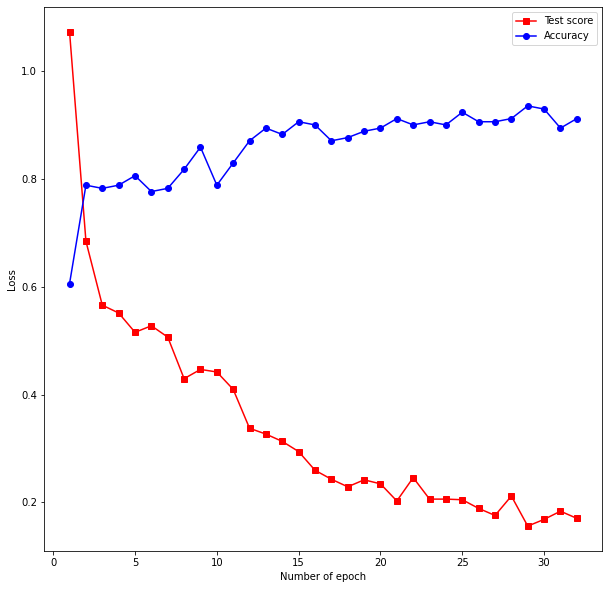

In [9]:
epoch_list_plot=[]
for i in range(32):
    epoch_list_plot.append(i+1)

plt.figure(figsize=(10, 10))
plt.plot(epoch_list_plot, loss_list,'s-',color='r',label='Test score')
plt.plot(epoch_list_plot, accuracy_list,'o-',color='b',label='Accuracy')
plt.xlabel("Number of epoch")
plt.ylabel("Loss")
plt.legend(loc = "best")
plt.show()

### Have a look on some random images from validate loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


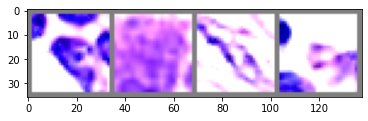

GroundTruth:  Immune Cancer Connective Connective


In [10]:
dataiter = iter(validate_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))


Predicted:  Immune Cancer Connective Connective


### Calculate accuracy of validate data set

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} validate images: {100 * correct // total} %')

Accuracy of the network on the 170 validate images: 91 %


### Caculate accuracy by group of labels

In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Cancer is 85.5 %
Accuracy for class: Connective is 92.3 %
Accuracy for class: Immune is 100.0 %
Accuracy for class: Normal is 89.5 %


### Confusion matrix plot for validate data set

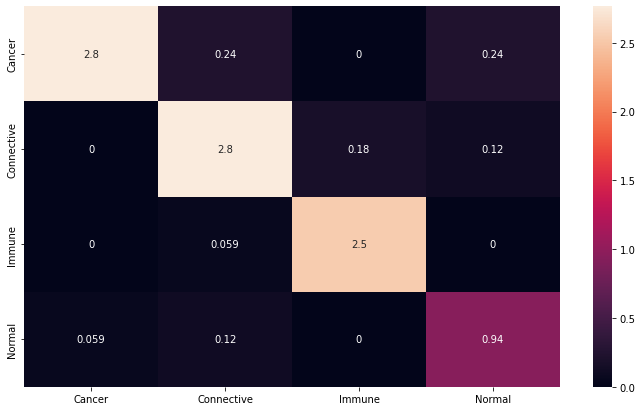

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in validate_loader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Cancer', 'Connective', 'Immune', 'Normal')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### Get all predictions for test data set

In [15]:
total_pred = []

# again no gradients needed
with torch.no_grad():
    net.eval()
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for prediction in predictions:
            total_pred.append(classes[prediction])

In [16]:
import re
def file_name(text):
    matchObj = re.findall( r'tile[0-9]*', text)
    result = matchObj[0]+'.png'
    return result

total_file_name = []
for i in test_set.imgs:
    temp =file_name(i[0])
    total_file_name.append(temp)

### Save test predictions in csv then submit on kaggle

In [17]:
import pandas as pd
data = {'Id': total_file_name, 'Type': total_pred}
df = pd.DataFrame.from_dict(data)
df.head
df.to_csv('prediction_12.csv', index=False)

### Label distribution for test data set predictions

In [18]:
Counter(df['Type'])

Counter({'Connective': 981, 'Normal': 857, 'Cancer': 794, 'Immune': 568})

### Autoencoder CNN

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
def train(model, num_epochs=5, batch_size=4, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    outputs = []
    for epoch in range(num_epochs):
        for data in test_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

### Train Autoencoder with unlabelde test data

In [21]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.4807
Epoch:2, Loss:0.4745
Epoch:3, Loss:0.4728
Epoch:4, Loss:0.4714
Epoch:5, Loss:0.4707
Epoch:6, Loss:0.4704
Epoch:7, Loss:0.4701
Epoch:8, Loss:0.4697
Epoch:9, Loss:0.4698
Epoch:10, Loss:0.4694
Epoch:11, Loss:0.4694
Epoch:12, Loss:0.4692
Epoch:13, Loss:0.4689
Epoch:14, Loss:0.4691
Epoch:15, Loss:0.4689
Epoch:16, Loss:0.4690
Epoch:17, Loss:0.4690
Epoch:18, Loss:0.4686
Epoch:19, Loss:0.4688
Epoch:20, Loss:0.4687


### Show some images before autoencoder and after autoencoder

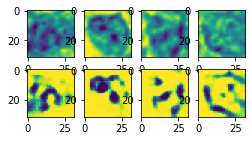

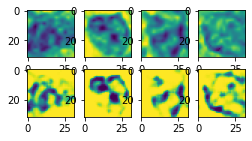

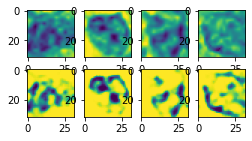

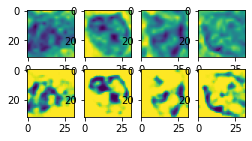

In [22]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


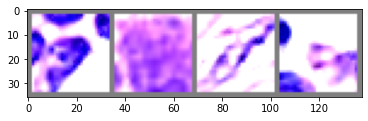

GroundTruth:  Immune Cancer Connective Connective


In [34]:
dataiter = iter(validate_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
64*5*5

### Use encoder part to create a new CNN

In [51]:
class Net_AE(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = x.view(-1,64*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_ae = Net_AE()

In [52]:
print(net_ae)

Net_AE(
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### Train this new CNN with labeled train data

In [57]:
for epoch in range(32):  # loop over the dataset multiple times

    running_loss = 0.0
    batch_count = 0
    net_ae.train()
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        inputs_embedding = model.encoder(inputs)
        # forward + backward + optimize
        outputs = net_ae(inputs_embedding.flatten())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        batch_count += 1


    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/batch_count:.3f}')
    running_loss = 0.0
print('Finished Training')

[1,   383] loss: 1.402
[2,   383] loss: 1.392
[3,   383] loss: 1.399
[4,   383] loss: 1.401
[5,   383] loss: 1.412
[6,   383] loss: 1.410
[7,   383] loss: 1.403
[8,   383] loss: 1.408
[9,   383] loss: 1.396
[10,   383] loss: 1.412
[11,   383] loss: 1.402
[12,   383] loss: 1.411
[13,   383] loss: 1.397
[14,   383] loss: 1.402
[15,   383] loss: 1.403
[16,   383] loss: 1.387
[17,   383] loss: 1.400
[18,   383] loss: 1.411
[19,   383] loss: 1.394
[20,   383] loss: 1.394
[21,   383] loss: 1.399
[22,   383] loss: 1.401
[23,   383] loss: 1.408
[24,   383] loss: 1.415
[25,   383] loss: 1.404
[26,   383] loss: 1.400
[27,   383] loss: 1.405
[28,   383] loss: 1.402
[29,   383] loss: 1.401
[30,   383] loss: 1.411
[31,   383] loss: 1.412
[32,   383] loss: 1.405
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


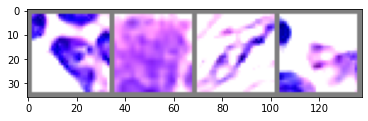

GroundTruth:  Immune Cancer Connective Connective


In [58]:
dataiter = iter(validate_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [59]:
inputs_embedding = model.encoder(images)
outputs = net_ae(inputs_embedding.flatten())
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  Normal Cancer Normal Normal


### Use validate data to calculate the accuracy

In [60]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        # calculate outputs by running images through the network
        inputs_embedding = model.encoder(images)
        outputs = net_ae(inputs_embedding.flatten())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 170 test images: 31 %


In [61]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in validate_loader:
        images, labels = data
        inputs_embedding = model.encoder(images)
        outputs = net_ae(inputs_embedding.flatten())
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Cancer is 70.9 %
Accuracy for class: Connective is 9.6 %
Accuracy for class: Immune is 0.0 %
Accuracy for class: Normal is 42.1 %
